In [1]:
import pandas as pd
import pysam
from Bio.Seq import Seq
import gpplot
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from poola import core as pool


the difference between v1 and v2: v2 use z-score relative to negative control like how we calcualted in our tiling screen 

In [2]:
in_path = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/Comp Data Sets/Tiling Library/CRISPRi/Nunez 2021/'
nunez_tiling_sgrna = pd.read_excel(in_path + '1-s2.0-S0092867421003536-mmc4.xlsx', 
                             sheet_name = 'Tiling protospacers',
                            skiprows = 3, header=0)
nunez_tiling_phenotype = pd.read_excel(in_path + '1-s2.0-S0092867421003536-mmc4.xlsx', 
                             sheet_name = 'CRISPRi-K562',
                            skiprows = 3, header=[0, 1])


In [3]:
nunez_tiling_sgrna.head()

,Unnamed: 0,gene,sequence
0,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT
1,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC
2,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA
3,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG
4,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG


In [4]:
len(nunez_tiling_sgrna)

116085

In [5]:
nunez_tiling_sgrna = nunez_tiling_sgrna.rename(columns={'Unnamed: 0': 'ID'})
nunez_tiling_phenotype.head()

Unnamed: 0_level_0   Counts                                     \
                  id T0, Rep1 T0, Rep2 Tfinal, Rep1 Tfinal, Rep2   
0  ACTR6_+_100592059      957      826         1038          788   
1  ACTR6_+_100592060      758      739          945          914   
2  ACTR6_+_100592066      992      698         1021          922   
3  ACTR6_+_100592067      958      849          952         1023   
4  ACTR6_+_100592092      182      148          168          219   

                 Phenotype scores                          
  Tfinal, Rep2.1             Rep1      Rep2 ave_Rep1_Rep2  
0            NaN        -0.001747 -0.036016     -0.018881  
1            NaN         0.017515  0.001070      0.009292  
2            NaN        -0.009000  0.010468      0.000734  
3            NaN        -0.013854 -0.002658     -0.008256  
4            NaN        -0.024057  0.026685      0.001314

In [6]:
nunez_tiling_phenotype.columns = [f'{i}-{j}' for i, j in nunez_tiling_phenotype.columns]
nunez_tiling_phenotype = nunez_tiling_phenotype.rename(columns={'Unnamed: 0_level_0-id': 'ID'})
nunez_tiling = pd.merge(nunez_tiling_sgrna, nunez_tiling_phenotype, on = 'ID')

In [7]:
nunez_tiling.head()

,ID,gene,sequence,"Counts-T0, Rep1","Counts-T0, Rep2","Counts-Tfinal, Rep1","Counts-Tfinal, Rep2","Counts-Tfinal, Rep2.1",Phenotype scores-Rep1,Phenotype scores-Rep2,Phenotype scores-ave_Rep1_Rep2
0,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT,957,826,1038,788,NaN,-0.001747,-0.036016,-0.018881
1,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC,758,739,945,914,NaN,0.017515,0.001070,0.009292
2,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA,992,698,1021,922,NaN,-0.009000,0.010468,0.000734
3,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG,958,849,952,1023,NaN,-0.013854,-0.002658,-0.008256
4,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG,182,148,168,219,NaN,-0.024057,0.026685,0.001314


In [8]:
nunez_tiling.drop('Counts-Tfinal, Rep2.1', axis=1, inplace=True)

In [9]:
nunez_tiling.columns

Index(['ID', 'gene', 'sequence', 'Counts-T0, Rep1', 'Counts-T0, Rep2',
       'Counts-Tfinal, Rep1', 'Counts-Tfinal, Rep2', 'Phenotype scores-Rep1',
       'Phenotype scores-Rep2', 'Phenotype scores-ave_Rep1_Rep2'],
      dtype='object')

#### growth phenotype is defined in the supple figure 1 of gilbert 2014

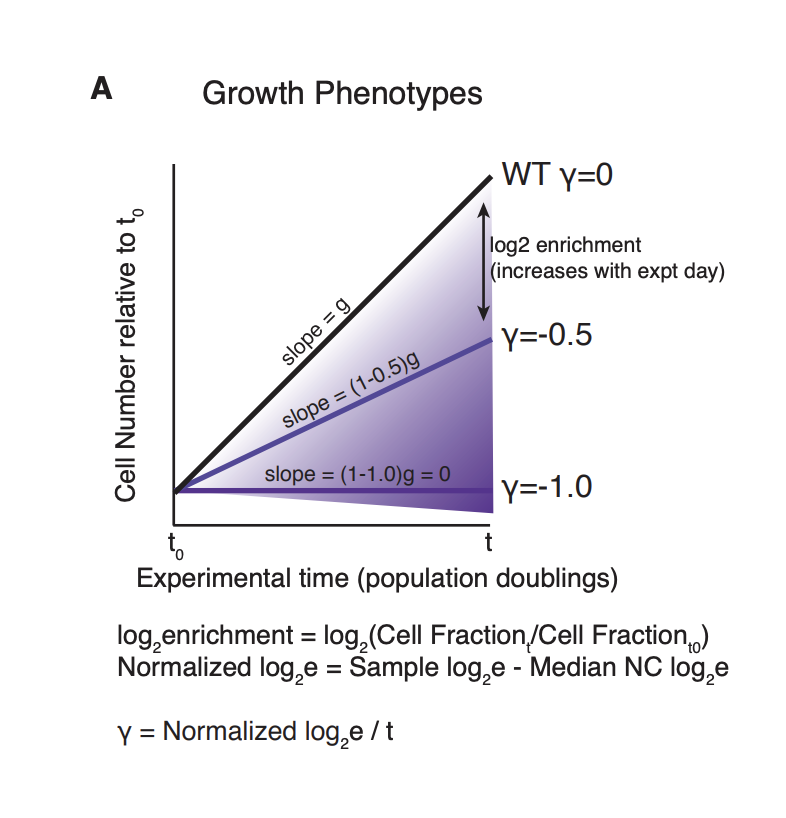

In [10]:
# use count to calcuate LFC: remove T0 with z-score less than -3
lognorms_nunez_tiling = pool.lognorm_columns(reads_df=nunez_tiling, columns=['Counts-T0, Rep1', 'Counts-T0, Rep2', 
                                                                          'Counts-Tfinal, Rep1', 'Counts-Tfinal, Rep2'])
filtered_lognorms_nunez_tiling = pool.filter_pdna(lognorm_df=lognorms_nunez_tiling, 
                                                  pdna_cols=['Counts-T0, Rep1', 'Counts-T0, Rep2'], z_low=-3)
print('Filtered ' + str(lognorms_nunez_tiling.shape[0] - filtered_lognorms_nunez_tiling.shape[0]) + ' rows due to low pDNA abundance')


Filtered 856 rows due to low pDNA abundance


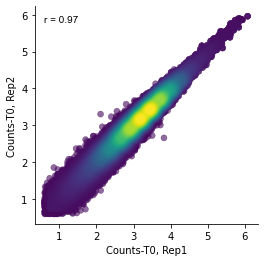

In [11]:
# use count to calcuate LFC: check lognorms of T0 repeats correlation 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=filtered_lognorms_nunez_tiling, x='Counts-T0, Rep1', y='Counts-T0, Rep2')
gpplot.add_correlation(data=filtered_lognorms_nunez_tiling, x='Counts-T0, Rep1', y='Counts-T0, Rep2')
sns.despine()

In [12]:
# use count to calcuate LFC: find average lognorms of T0 because they corrlate well
filtered_lognorms_nunez_tiling['Avg Counts-T0'] = filtered_lognorms_nunez_tiling[['Counts-T0, Rep1', 'Counts-T0, Rep2']].mean(axis=1)

In [13]:
# use count to calcuate LFC: calcuate LFC relative to the averaged T0 lognmorm 
lfc_nunez_tiling = pool.calculate_lfcs(lognorm_df=filtered_lognorms_nunez_tiling, 
                                         ref_col='Avg Counts-T0', 
                                       target_cols=['Counts-Tfinal, Rep1', 'Counts-Tfinal, Rep2'])
lfc_nunez_tiling.head()


,ID,gene,sequence,"Counts-T0, Rep1","Counts-T0, Rep2","Counts-Tfinal, Rep1","Counts-Tfinal, Rep2",Phenotype scores-Rep1,Phenotype scores-Rep2,Phenotype scores-ave_Rep1_Rep2
0,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT,3.565329,3.545223,0.196776,-0.126569,-0.001747,-0.036016,-0.018881
1,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC,3.260654,3.399132,0.297239,0.294224,0.017515,0.001070,0.009292
2,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA,3.612844,3.324795,0.261191,0.166854,-0.009000,0.010468,0.000734
3,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG,3.566709,3.581494,0.062819,0.200034,-0.013854,-0.002658,-0.008256
4,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG,1.614054,1.542271,0.015828,0.315110,-0.024057,0.026685,0.001314


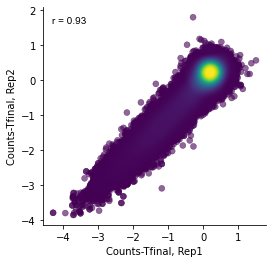

In [14]:
#  check LFC of Tfinal repeats correlation 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_nunez_tiling, x='Counts-Tfinal, Rep1', y='Counts-Tfinal, Rep2')
gpplot.add_correlation(data=lfc_nunez_tiling, x='Counts-Tfinal, Rep1', y='Counts-Tfinal, Rep2')
sns.despine()

In [15]:
# find average LFC of Tfinal because they corrlate well
lfc_nunez_tiling['Avg_LFC-Tfinal'] = lfc_nunez_tiling[['Counts-Tfinal, Rep1', 'Counts-Tfinal, Rep2']].mean(axis=1)


In [16]:
# calcuate z-score relative to neg control
nc_mean = lfc_nunez_tiling[lfc_nunez_tiling.gene == 'negative_control']['Avg_LFC-Tfinal'].mean()
nc_mean_std = lfc_nunez_tiling[lfc_nunez_tiling.gene == 'negative_control']['Avg_LFC-Tfinal'].std()
lfc_nunez_tiling['z-score relative to NC'] = (lfc_nunez_tiling['Avg_LFC-Tfinal'] - nc_mean)/nc_mean_std

In [17]:
lfc_nunez_tiling.head()

,ID,gene,sequence,"Counts-T0, Rep1","Counts-T0, Rep2","Counts-Tfinal, Rep1","Counts-Tfinal, Rep2",Phenotype scores-Rep1,Phenotype scores-Rep2,Phenotype scores-ave_Rep1_Rep2,Avg_LFC-Tfinal,z-score relative to NC
0,ACTR6_+_100592059,ACTR6,GCGAGCACATAGAGGGATCT,3.565329,3.545223,0.196776,-0.126569,-0.001747,-0.036016,-0.018881,0.035104,-0.889828
1,ACTR6_+_100592060,ACTR6,GTCGAGCACATAGAGGGATC,3.260654,3.399132,0.297239,0.294224,0.017515,0.001070,0.009292,0.295731,0.580559
2,ACTR6_+_100592066,ACTR6,GCCTGCTTCGAGCACATAGA,3.612844,3.324795,0.261191,0.166854,-0.009000,0.010468,0.000734,0.214023,0.119582
3,ACTR6_+_100592067,ACTR6,GACCTGCTTCGAGCACATAG,3.566709,3.581494,0.062819,0.200034,-0.013854,-0.002658,-0.008256,0.131427,-0.346402
4,ACTR6_+_100592092,ACTR6,GAGACTCTGTCACCTCCGAG,1.614054,1.542271,0.015828,0.315110,-0.024057,0.026685,0.001314,0.165469,-0.154343


In [18]:
lfc_nunez_tiling_cleaned = lfc_nunez_tiling.dropna()

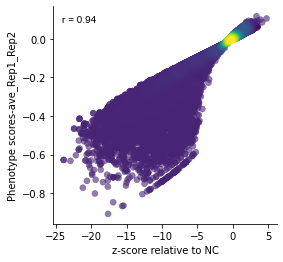

In [19]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_nunez_tiling_cleaned, x='z-score relative to NC', y='Phenotype scores-ave_Rep1_Rep2')
gpplot.add_correlation(data=lfc_nunez_tiling_cleaned, x='z-score relative to NC', y='Phenotype scores-ave_Rep1_Rep2')
sns.despine()

In [20]:
lfc_nunez_tiling_cleaned = lfc_nunez_tiling_cleaned[['ID','gene','sequence', 'Phenotype scores-ave_Rep1_Rep2', 'z-score relative to NC','Avg_LFC-Tfinal']]


In [21]:
# remove neg controls
nunez_tiling_rm_nc = lfc_nunez_tiling_cleaned[lfc_nunez_tiling_cleaned.gene != 'negative_control'].copy()

In [22]:
# split the column
nunez_tiling_rm_nc['strand'] = nunez_tiling_rm_nc.ID.str.split("_").str[1]
nunez_tiling_rm_nc['coord'] = nunez_tiling_rm_nc.ID.str.split("_").str[2]

In [23]:
# import crispick results to get gene chr 
gene_crispick = pd.read_table('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2023/cleaned_crispri_datasets/temp_data_clean/Nunez 2021/gene-set-sgrna-designs.txt')

In [24]:
#need to find chrom for genes have differnt name in CRISPick and CRISPRi
miss_gene = set(nunez_tiling_rm_nc.gene.unique()) ^ set(set(gene_crispick['Target Gene Symbol']) & 
                                                set(nunez_tiling_rm_nc.gene.unique()))
# number of genes have differnt name in CRISPick and CRISPRi
len(miss_gene)

23

In [25]:
gene_set= pd.read_csv('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2023/cleaned_crispri_datasets/temp_data_clean/Nunez 2021/gene_set.csv', header = None)
gene_set = gene_set[~gene_set[0].isin(['EFTUD1', 'QARS', 'SARS'])][0].dropna().tolist()
# EFTUD1 is a novel transcript and coundn't find the exact match for QARS and SARS
gene_crispick['input gene'] = gene_set

In [26]:
# new name for the updated gene name
merge_gene_name = gene_crispick[['Target Gene Symbol', 'input gene']].copy()
merge_gene_name[merge_gene_name['input gene'].isin(miss_gene)]

,Target Gene Symbol,input gene
6,ATP5F1B,ATP5B
23,NOPCHAP1,C12orf45
24,RTRAF,C14orf166
28,CARS1,CARS
36,POLR1G,CD3EAP
79,DARS1,DARS
97,UTP25,DIEXF
203,MICOS10-NBL1,MINOS1-NBL1
204,MICOS10,MINOS1
207,NIFK,MKI67IP


In [27]:
gene_crispick = gene_crispick[['Target Gene Symbol', 'input gene']]


In [28]:
nunez_tiling_rm_nc = pd.merge(gene_crispick, nunez_tiling_rm_nc.rename(columns = {'gene':'input gene' }))

In [29]:
nunez_tiling_rm_nc

,Target Gene Symbol,input gene,ID,sequence,Phenotype scores-ave_Rep1_Rep2,z-score relative to NC,Avg_LFC-Tfinal,strand,coord
0,ACTR6,ACTR6,ACTR6_+_100592059,GCGAGCACATAGAGGGATCT,-0.018881,-0.889828,0.035104,+,100592059
1,ACTR6,ACTR6,ACTR6_+_100592060,GTCGAGCACATAGAGGGATC,0.009292,0.580559,0.295731,+,100592060
2,ACTR6,ACTR6,ACTR6_+_100592066,GCCTGCTTCGAGCACATAGA,0.000734,0.119582,0.214023,+,100592066
3,ACTR6,ACTR6,ACTR6_+_100592067,GACCTGCTTCGAGCACATAG,-0.008256,-0.346402,0.131427,+,100592067
4,ACTR6,ACTR6,ACTR6_+_100592092,GAGACTCTGTCACCTCCGAG,0.001314,-0.154343,0.165469,+,100592092
...,...,...,...,...,...,...,...,...,...
110795,POLR1H,ZNRD1,ZNRD1_-_30030008,GAGTTTCTTCCCAGGTTGAC,-0.019556,-0.939122,0.026366,-,30030008
110796,POLR1H,ZNRD1,ZNRD1_-_30030025,GACAGGCGCTGCCCTCGATG,-0.002665,-0.049512,0.184051,-,30030025
110797,POLR1H,ZNRD1,ZNRD1_-_30030034,GGCCCTCGATGTGGTCATGA,0.018245,1.084883,0.385123,-,30030034
110798,POLR1H,ZNRD1,ZNRD1_-_30030076,GAGATGCGTTCAGCCGATGA,0.008562,0.507018,0.282696,-,30030076


In [30]:
# cleaned dataset
outpath = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2024/Manuscript/CleanedData/'
NewDatasetCombine = pd.read_csv(outpath + 'DatasetCombineCleaned.csv', low_memory=False)

In [31]:
nunez_tiling_rm_nc = nunez_tiling_rm_nc[['Target Gene Symbol', 'sequence', 'Phenotype scores-ave_Rep1_Rep2',
       'z-score relative to NC','Avg_LFC-Tfinal', 'strand']].rename(columns = {'sequence': 'sgRNA Sequence',
                                                                   'strand': "Strand of gRNA"})

In [32]:
NewDatasetCombineNunez = NewDatasetCombine[NewDatasetCombine.DataSet == 'Nunez']

In [33]:
combinedNunez = pd.merge(nunez_tiling_rm_nc,NewDatasetCombineNunez ,how = 'inner', 
                         on = ['Target Gene Symbol', 'sgRNA Sequence'])

In [34]:
combinedNunez['sgRNA Sequence'].value_counts()

GCGAGCACATAGAGGGATCT    1
GTATCTTATTCACCCTCTGA    1
GGAATGGGCATCTTAAAGGT    1
GAGAATGGGCATCTTAAAGG    1
GGTGAGAATGGGCATCTTAA    1
                       ..
GAAGCCGAAAGGAGAGGAGC    1
GGTGGGGAAGCCGAAAGGAG    1
GGCACCGTGGGGAAGCCGAA    1
GAATCCCGAAAGGCACCGTG    1
GGATGCGTTCAGCCGATGAA    1
Name: sgRNA Sequence, Length: 71517, dtype: int64

In [35]:
combinedNunez.head()

,Target Gene Symbol,sgRNA Sequence,Phenotype scores-ave_Rep1_Rep2,z-score relative to NC,Avg_LFC-Tfinal,Strand of gRNA,chromosome,sgRNA Context Sequence,sgRNA 'Cut' Position,Strand of Target,TSS Position,sgRNA 'Cut' Site TSS Offset,orginal phenotype,condition,Domain,DataSet,metrics
0,ACTR6,GCGAGCACATAGAGGGATCT,-0.018881,-0.889828,0.035104,+,chr12,TGCTTCGAGCACATAGAGGGATCTGGGCCC,100198288.0,+,100200816.0,-2528.0,-0.018881,K562,Kox1,Nunez,Phenotype scores
1,ACTR6,GTCGAGCACATAGAGGGATC,0.009292,0.580559,0.295731,+,chr12,CTGCTTCGAGCACATAGAGGGATCTGGGCC,100198289.0,+,100200816.0,-2527.0,0.009292,K562,Kox1,Nunez,Phenotype scores
2,ACTR6,GCCTGCTTCGAGCACATAGA,0.000734,0.119582,0.214023,+,chr12,GTCCACCTGCTTCGAGCACATAGAGGGATC,100198295.0,+,100200816.0,-2521.0,0.000734,K562,Kox1,Nunez,Phenotype scores
3,ACTR6,GACCTGCTTCGAGCACATAG,-0.008256,-0.346402,0.131427,+,chr12,GGTCCACCTGCTTCGAGCACATAGAGGGAT,100198296.0,+,100200816.0,-2520.0,-0.008256,K562,Kox1,Nunez,Phenotype scores
4,ACTR6,GAGACTCTGTCACCTCCGAG,0.001314,-0.154343,0.165469,+,chr12,GGGCTAGACTCTGTCACCTCCGAGGGGTCC,100198321.0,+,100200816.0,-2495.0,0.001314,K562,Kox1,Nunez,Phenotype scores


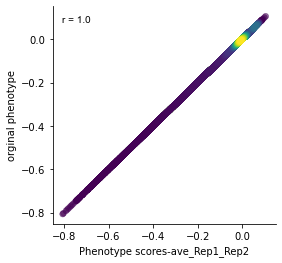

In [36]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=combinedNunez, x='Phenotype scores-ave_Rep1_Rep2', y='orginal phenotype')
gpplot.add_correlation(data=combinedNunez, x='Phenotype scores-ave_Rep1_Rep2', y='orginal phenotype')
sns.despine()

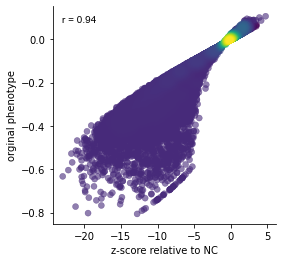

In [37]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=combinedNunez, x='z-score relative to NC', y='orginal phenotype')
gpplot.add_correlation(data=combinedNunez, x='z-score relative to NC', y='orginal phenotype')
sns.despine()

In [38]:
combinedNunez = combinedNunez[['Target Gene Symbol', 'Strand of gRNA', 'Strand of Target', 'chromosome', 
                               'sgRNA Sequence', 'sgRNA Context Sequence', 'sgRNA \'Cut\' Position', 
                               'TSS Position', 'sgRNA \'Cut\' Site TSS Offset', 
                               'Phenotype scores-ave_Rep1_Rep2', 'z-score relative to NC','Avg_LFC-Tfinal',
                               'condition', 'Domain', 'DataSet']]

In [39]:
combinedNunez.to_csv('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2024/Manuscript/Nunez/NunezCleaned2024.csv',
                    index = False)

In [40]:
nunez_tiling_rm_nc_V2 = nunez_tiling_rm_nc[nunez_tiling_rm_nc['sgRNA Sequence'].isin(NewDatasetCombineNunez['sgRNA Sequence'])]

In [41]:
nunez_tiling_rm_nc_V2['sgRNA Sequence'].value_counts()

GCATCCGGCCCCCGTGGAGA    2
GCCACCTCACGCCCTGTTCC    2
GTAGCAACATTGGAAATGGG    2
GTTGTAGCAACATTGGAAAT    2
GTCGGGTGTTGTAGCAACAT    2
                       ..
GCATGCGCAGGGCTCGCGCC    1
GGACCCAACGGGCATGCGCA    1
GGGACCCAACGGGCATGCGC    1
GTCGGCCTCCGGGACCCAAC    1
GGATGCGTTCAGCCGATGAA    1
Name: sgRNA Sequence, Length: 71517, dtype: int64

In [42]:
tryv1 = pd.merge(NewDatasetCombineNunez, nunez_tiling_rm_nc_V2, on = ['Target Gene Symbol','sgRNA Sequence'])
tryv2 = pd.merge(NewDatasetCombineNunez, nunez_tiling_rm_nc_V2, on = 'sgRNA Sequence')

In [43]:
tryv2[~tryv2['sgRNA Sequence'].isin(tryv1['sgRNA Sequence'])]

,Target Gene Symbol_x,chromosome,sgRNA Sequence,sgRNA Context Sequence,sgRNA 'Cut' Position,Strand of Target,TSS Position,sgRNA 'Cut' Site TSS Offset,orginal phenotype,condition,Domain,DataSet,metrics,Target Gene Symbol_y,Phenotype scores-ave_Rep1_Rep2,z-score relative to NC,Avg_LFC-Tfinal,Strand of gRNA
